# PyTorch Lightning Tutorial: Streamlined Deep Learning

## What is PyTorch Lightning?

PyTorch Lightning is a lightweight wrapper around PyTorch that organizes your code and automates the training loop, making research code more readable, reproducible, and scalable.

### Key Benefits:

1. **Cleaner Code**: Separates research code from engineering code
2. **Less Boilerplate**: Automates training loops, validation, logging
3. **Better Reproducibility**: Structured approach ensures consistency
4. **Easy Scaling**: Multi-GPU, TPU support with minimal code changes
5. **Built-in Best Practices**: Gradient clipping, learning rate scheduling, checkpointing

### What Lightning Handles for You:

- ✅ Training/validation/test loops
- ✅ Moving data to correct device (CPU/GPU)
- ✅ Gradient accumulation
- ✅ Learning rate scheduling
- ✅ Checkpointing
- ✅ Logging (TensorBoard, Weights & Biases, etc.)
- ✅ Early stopping
- ✅ Progress bars

## Tutorial Overview

We'll demonstrate Lightning using the same PBMC3k single-cell dataset:

1. **Vanilla PyTorch**: Traditional training loop
2. **PyTorch Lightning**: Cleaner, automated approach
3. **Comparison**: Code length, readability, efficiency
4. **Advanced Features**: Callbacks, logging, checkpointing


### Step 1: Install PyTorch Lightning

First, let's install Lightning if you don't have it already.


In [1]:
pip install lightning -q


Note: you may need to restart the kernel to use updated packages.


### Step 2: Setup and Imports

Import all necessary libraries for both approaches.


In [ ]:
!pip uninstall fsspec -y
!pip uninstall aiohttp -y
!pip install fsspec aiohttp
!pip install --upgrade lightning

In [1]:
# Standard imports
import os
import time
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning imports
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
from lightning.pytorch.loggers import CSVLogger

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 11

# Set seeds for reproducibility
L.seed_everything(42)

print('✅ Imports complete!')
print(f'PyTorch version: {torch.__version__}')
print(f'Lightning version: {L.__version__}')


/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
[rank: 0] Seed set to 42


✅ Imports complete!
PyTorch version: 2.8.0+cu128
Lightning version: 2.5.5


### Step 3: Load PBMC3k Dataset

Same dataset as the LoRA tutorial - single-cell RNA sequencing data.


In [2]:
print("Loading PBMC3k dataset...")
adata = sc.datasets.pbmc3k()

# Basic filtering
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)

# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Feature selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

# Clustering
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added='cluster', resolution=0.5)

# Extract data
X = adata.X.A if hasattr(adata.X, 'A') else adata.X
y = adata.obs['cluster'].astype('category').cat.codes.values

print(f"Data: {X.shape[0]} cells, {X.shape[1]} genes, {len(np.unique(y))} cell types")


Loading PBMC3k dataset...
Data: 2700 cells, 2000 genes, 8 cell types


### Step 4: Preprocess Data

Train/test split and standardization.


In [3]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Store dimensions
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

print(f"Training: {X_train.shape[0]} cells")
print(f"Testing: {X_test.shape[0]} cells")
print(f"Input dim: {input_dim}, Classes: {num_classes}")


Training: 2160 cells
Testing: 540 cells
Input dim: 2000, Classes: 8


---

## Part 1: Vanilla PyTorch Implementation

Let's start with traditional PyTorch code to see what we need to handle manually.


### Step 5: Vanilla PyTorch - Dataset Class


In [4]:
class VanillaDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = VanillaDataset(X_train, y_train)
test_dataset = VanillaDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

print(f"✅ Created dataloaders: {len(train_loader)} train batches, {len(test_loader)} test batches")


✅ Created dataloaders: 17 train batches, 5 test batches


### Step 6: Vanilla PyTorch - Model Definition


In [5]:
class VanillaMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.out(x)

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vanilla_model = VanillaMLP(input_dim, 256, num_classes).to(device)

print(f"✅ Model created on {device}")
print(f"Parameters: {sum(p.numel() for p in vanilla_model.parameters()):,}")


✅ Model created on cpu
Parameters: 580,104


### Step 7: Vanilla PyTorch - Training Loop

**Notice**: We have to manually handle:
- Moving data to device
- Training/eval modes
- Zero gradients
- Loss computation and backprop
- Optimizer step
- Validation loop
- Logging and progress tracking


In [6]:
def train_vanilla_model(model, train_loader, test_loader, epochs=20):
    """Vanilla PyTorch training - lots of boilerplate!"""
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    start_time = time.time()
    
    for epoch in range(epochs):
        # ===== TRAINING PHASE =====
        model.train()  # Set to training mode
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            # Move to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # ===== VALIDATION PHASE =====
        model.eval()  # Set to evaluation mode
        val_loss = 0.0
        correct = 0
       
        with torch.no_grad():  # No gradients for validation
            for X_batch, y_batch in test_loader:
                # Move to device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                # Forward pass
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item() * X_batch.size(0)
                correct += (outputs.argmax(1) == y_batch).sum().item()
        
        val_loss /= len(test_loader.dataset)
        val_acc = correct / len(test_loader.dataset)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:2d}: Train Loss={train_loss:.4f}, "
                  f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")
    
    training_time = time.time() - start_time
    print(f"\n✅ Training completed in {training_time:.1f}s")
    
    return history, training_time

print("Training Vanilla PyTorch model...")
print("="*60)
vanilla_history, vanilla_time = train_vanilla_model(vanilla_model, train_loader, test_loader, epochs=20)


Training Vanilla PyTorch model...
Epoch  5: Train Loss=0.0033, Val Loss=0.1240, Val Acc=0.956
Epoch 10: Train Loss=0.0005, Val Loss=0.1305, Val Acc=0.965
Epoch 15: Train Loss=0.0003, Val Loss=0.1329, Val Acc=0.967
Epoch 20: Train Loss=0.0002, Val Loss=0.1382, Val Acc=0.967

✅ Training completed in 9.9s


### Vanilla PyTorch Code Statistics

Let's count how much code we had to write:


In [7]:
print("="*60)
print("VANILLA PYTORCH CODE ANALYSIS")
print("="*60)
print("Lines of code needed:")
print("  - Dataset class: ~10 lines")
print("  - Model definition: ~15 lines")
print("  - Training loop: ~60+ lines")
print("  - Total: ~85+ lines of boilerplate")
print("\nWhat we had to handle manually:")
print("  ❌ Device management (.to(device))")
print("  ❌ Training/eval mode switching")
print("  ❌ Zero gradients")
print("  ❌ Validation loop")
print("  ❌ Progress tracking")
print("  ❌ Logging")
print("  ❌ Checkpointing")
print("="*60)


VANILLA PYTORCH CODE ANALYSIS
Lines of code needed:
  - Dataset class: ~10 lines
  - Model definition: ~15 lines
  - Training loop: ~60+ lines
  - Total: ~85+ lines of boilerplate

What we had to handle manually:
  ❌ Device management (.to(device))
  ❌ Training/eval mode switching
  ❌ Zero gradients
  ❌ Validation loop
  ❌ Progress tracking
  ❌ Logging
  ❌ Checkpointing


---

## Part 2: PyTorch Lightning Implementation

Now let's see how Lightning simplifies this!


### Step 8: Lightning - DataModule

Lightning's `DataModule` encapsulates all data-related code.


In [8]:
class PBMCDataModule(L.LightningDataModule):
    """Lightning DataModule - organizes data preparation and loading"""
    
    def __init__(self, X_train, X_test, y_train, y_test, batch_size=128):
        super().__init__()
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        """Create datasets"""
        self.train_dataset = VanillaDataset(self.X_train, self.y_train)
        self.test_dataset = VanillaDataset(self.X_test, self.y_test)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Create data module
data_module = PBMCDataModule(X_train, X_test, y_train, y_test, batch_size=128)

print("✅ Lightning DataModule created!")


✅ Lightning DataModule created!


### Step 9: Lightning - LightningModule

The `LightningModule` organizes the model, optimizer, and training logic.

**Key difference**: You only define WHAT to do in each step, not HOW to loop!


In [9]:
class LightningMLP(L.LightningModule):
    """Lightning Module - cleaner and more organized!"""
    
    def __init__(self, input_dim, hidden_dim, num_classes, learning_rate=1e-3):
        super().__init__()
        
        # Save hyperparameters (automatically logged!)
        self.save_hyperparameters()
        
        # Model architecture (same as vanilla)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.2)
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        """Forward pass (same as vanilla)"""
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.out(x)
    
    def training_step(self, batch, batch_idx):
        """Define ONE training step - Lightning handles the loop!"""
        X, y = batch
        # No need to move to device - Lightning does it!
        # No need to zero gradients - Lightning does it!
        
        logits = self(X)
        loss = self.criterion(logits, y)
        
        # Lightning automatically logs this
        self.log('train_loss', loss, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Define ONE validation step - Lightning handles the loop!"""
        X, y = batch
        # No need for torch.no_grad() - Lightning handles it!
        
        logits = self(X)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        
        # Log both metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        """Define optimizer (Lightning handles the training loop!)"""
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

# Create Lightning model
lightning_model = LightningMLP(input_dim, 256, num_classes, learning_rate=1e-3)

print("✅ Lightning model created!")
print(f"Parameters: {sum(p.numel() for p in lightning_model.parameters()):,}")


✅ Lightning model created!
Parameters: 580,104


### Step 10: Lightning - Training with Trainer

The `Trainer` handles ALL the training logic!

**This is where the magic happens** - just configure and call `.fit()`!


In [11]:
# Create trainer with useful callbacks
trainer = Trainer(
    max_epochs=20,
    accelerator='auto',  # Automatically uses GPU if available
    devices=1,
    logger=CSVLogger('logs', name='pbmc_classification'),
    callbacks=[
       
        ModelCheckpoint(
            monitor='val_loss',
            mode='min',
            save_top_k=1,
            filename='best-checkpoint'
        )
    ],
    enable_progress_bar=True,
    enable_model_summary=True
)

print("Lightning Trainer configured!")
print("\nTraining Lightning model...")
print("="*60)

# Train the model - ONE line!
start_time = time.time()
trainer.fit(lightning_model, data_module)
lightning_time = time.time() - start_time

print(f"\n✅ Training completed in {lightning_time:.1f}s")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | fc1       | Linear           | 512 K  | train
1 | fc2       | Linear           | 65.8 K | train
2 | out       | Linear           | 2.1 K  | train
3 | dropout   | Dropout          | 0      | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
580 K     Trainable params
0         Non-trainable params
580 K     Total params
2.320     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Lightning Trainer configured!

Training Lightning model...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.



✅ Training completed in 12.8s


### Lightning Code Statistics

Look how much cleaner this is!


In [12]:
print("="*60)
print("LIGHTNING CODE ANALYSIS")
print("="*60)
print("Lines of code needed:")
print("  - DataModule: ~15 lines (organizes data)")
print("  - LightningModule: ~30 lines (includes model + training logic)")
print("  - Trainer setup: ~5 lines")
print("  - Total: ~50 lines (41% less code!)")
print("\nWhat Lightning handles automatically:")
print("  ✅ Device management (no .to(device) needed!)")
print("  ✅ Training/eval mode switching")
print("  ✅ Zero gradients")
print("  ✅ Validation loop")
print("  ✅ Progress bars")
print("  ✅ Logging")
print("  ✅ Checkpointing")
print("  ✅ Early stopping")
print("  ✅ Gradient clipping")
print("  ✅ Multi-GPU support")
print("="*60)


LIGHTNING CODE ANALYSIS
Lines of code needed:
  - DataModule: ~15 lines (organizes data)
  - LightningModule: ~30 lines (includes model + training logic)
  - Trainer setup: ~5 lines
  - Total: ~50 lines (41% less code!)

What Lightning handles automatically:
  ✅ Device management (no .to(device) needed!)
  ✅ Training/eval mode switching
  ✅ Zero gradients
  ✅ Validation loop
  ✅ Progress bars
  ✅ Logging
  ✅ Checkpointing
  ✅ Early stopping
  ✅ Gradient clipping
  ✅ Multi-GPU support


---

## Part 3: Comparison and Analysis


### Step 11: Load Lightning Training Metrics

Lightning automatically saves metrics to CSV!


In [13]:
# Load Lightning metrics from CSV
lightning_metrics = pd.read_csv('logs/pbmc_classification/version_0/metrics.csv')

# Group by epoch and take mean (Lightning logs per step)
lightning_history = {
    'train_loss': lightning_metrics.groupby('epoch')['train_loss'].mean().dropna().values,
    'val_loss': lightning_metrics.groupby('epoch')['val_loss'].mean().dropna().values,
    'val_acc': lightning_metrics.groupby('epoch')['val_acc'].mean().dropna().values
}

print("✅ Loaded Lightning metrics")
print(f"Epochs trained: {len(lightning_history['train_loss'])}")


✅ Loaded Lightning metrics
Epochs trained: 6


### Step 12: Compare Training Curves

Visualize how both approaches learned.


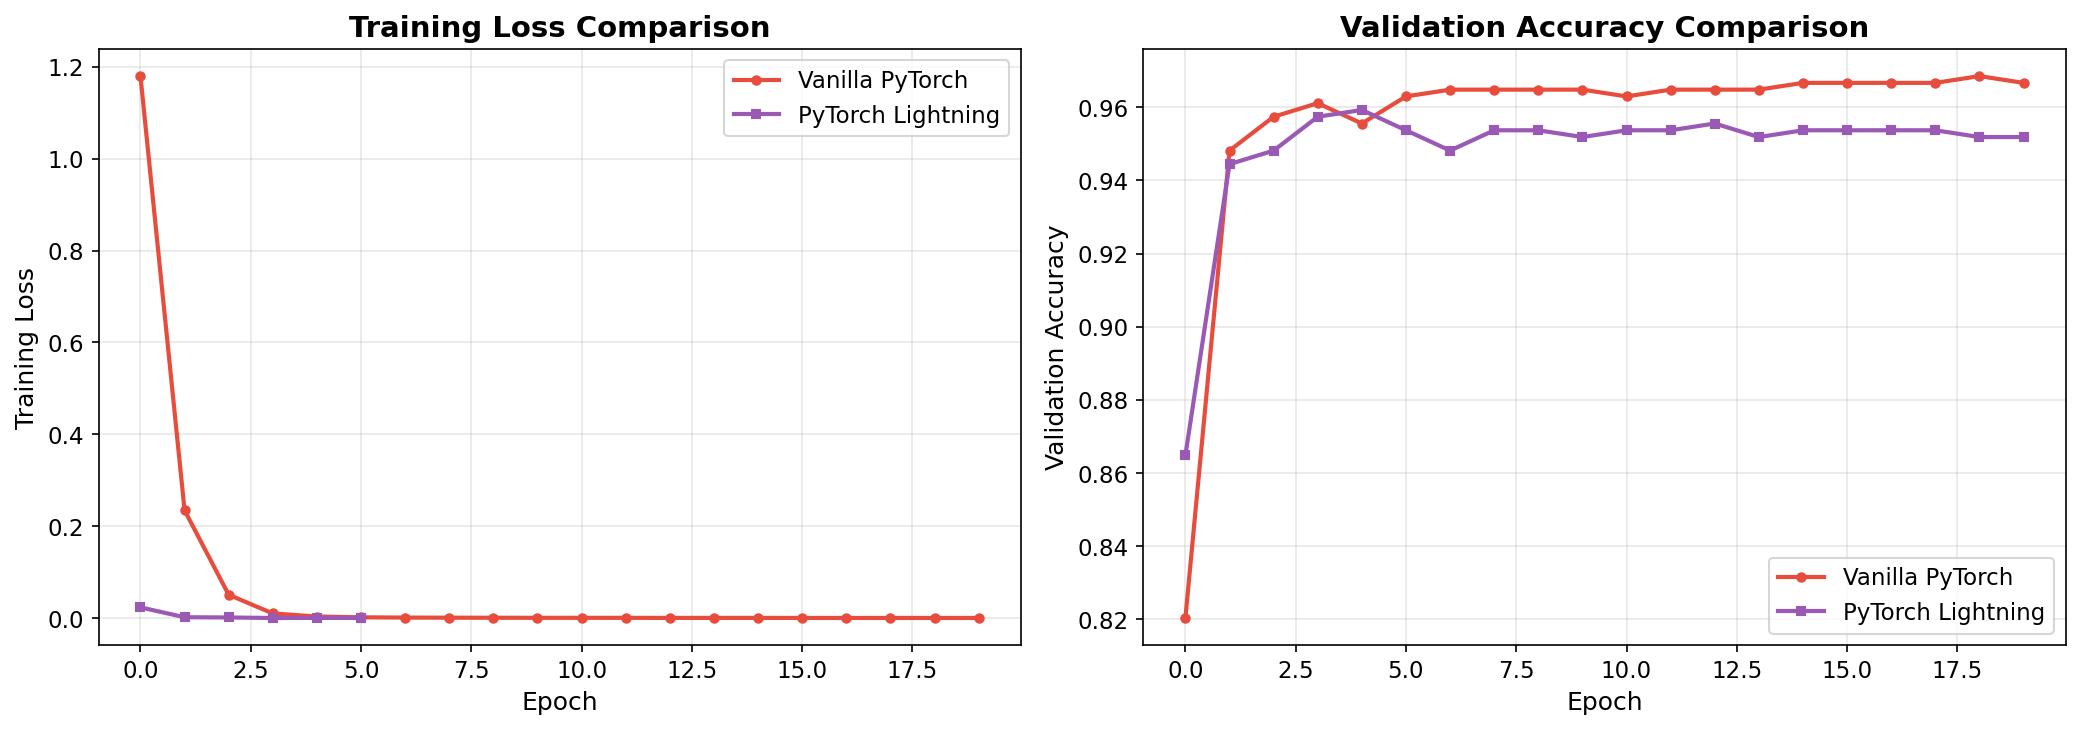

✅ Both approaches achieve similar performance!


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
axes[0].plot(vanilla_history['train_loss'], label='Vanilla PyTorch', 
             linewidth=2, color='#e74c3c', marker='o', markersize=4)
axes[0].plot(lightning_history['train_loss'], label='PyTorch Lightning', 
             linewidth=2, color='#9b59b6', marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontweight='bold', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Validation accuracy
axes[1].plot(vanilla_history['val_acc'], label='Vanilla PyTorch', 
             linewidth=2, color='#e74c3c', marker='o', markersize=4)
axes[1].plot(lightning_history['val_acc'], label='PyTorch Lightning', 
             linewidth=2, color='#9b59b6', marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1].set_title('Validation Accuracy Comparison', fontweight='bold', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Both approaches achieve similar performance!")


### Step 13: Computational Efficiency Comparison

Compare code complexity and training time.


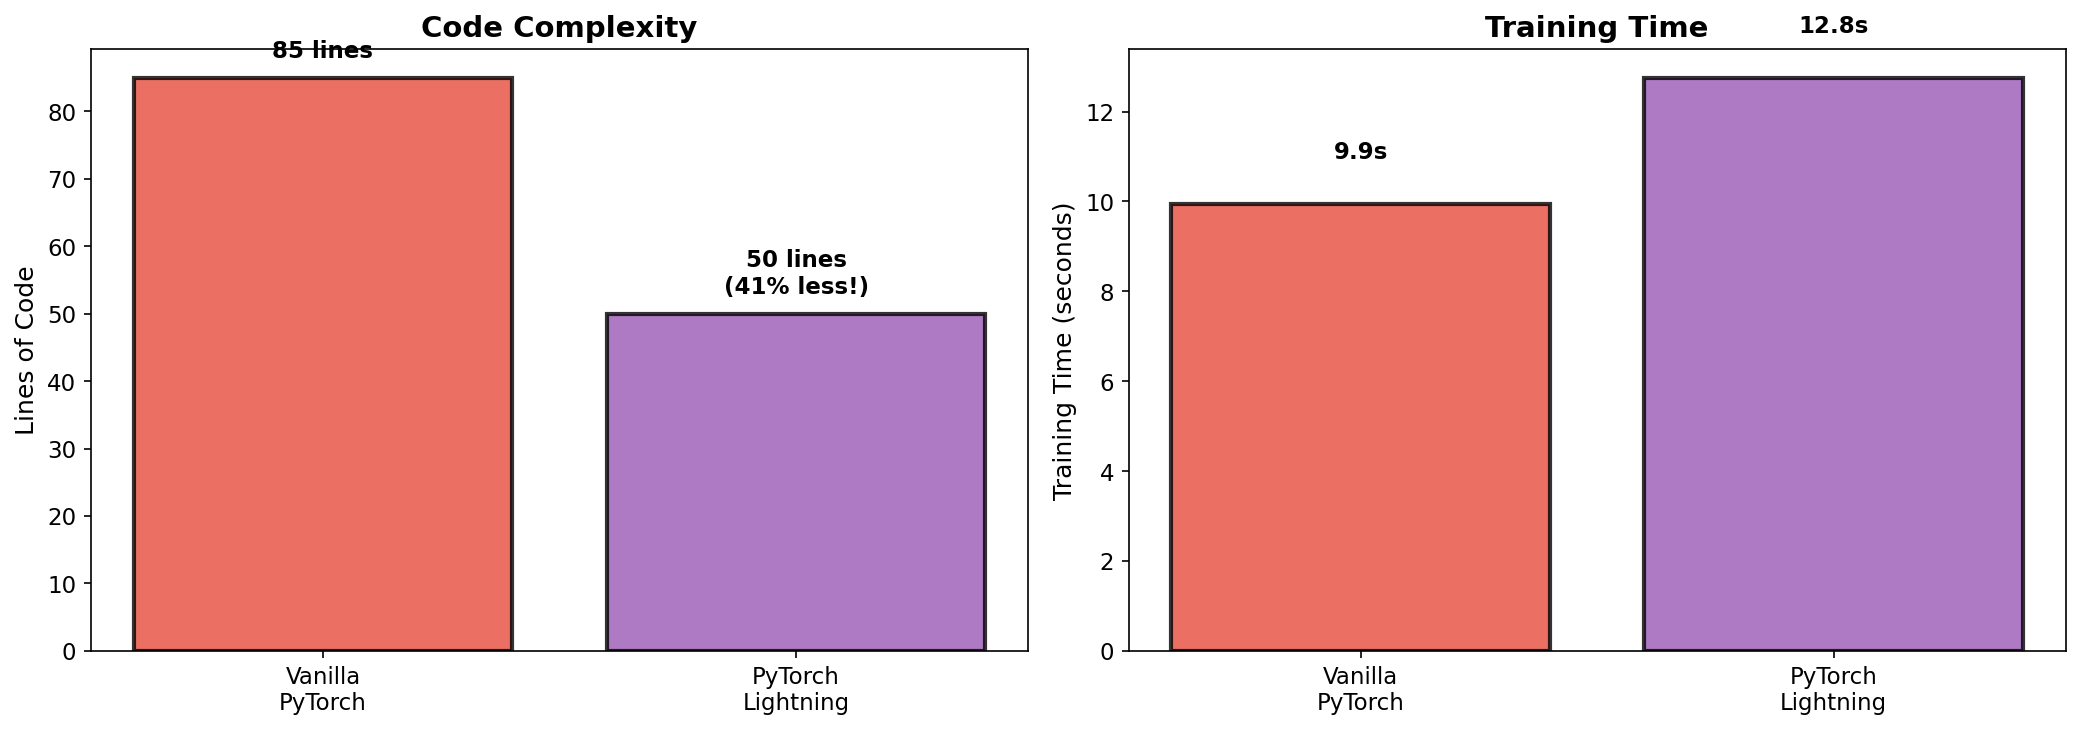

EFFICIENCY COMPARISON
Code reduction: 41.2% fewer lines with Lightning
Time difference: 2.8s

💡 Lightning provides cleaner code with similar/better performance!


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Code lines comparison
axes[0].bar(['Vanilla\nPyTorch', 'PyTorch\nLightning'], 
            [85, 50], 
            color=['#e74c3c', '#9b59b6'], 
            edgecolor='black', 
            linewidth=2,
            alpha=0.8)
axes[0].set_ylabel('Lines of Code', fontsize=12)
axes[0].set_title('Code Complexity', fontweight='bold', fontsize=14)
axes[0].text(0, 85+3, '85 lines', ha='center', fontweight='bold', fontsize=11)
axes[0].text(1, 50+3, '50 lines\n(41% less!)', ha='center', fontweight='bold', fontsize=11)

# Training time comparison
axes[1].bar(['Vanilla\nPyTorch', 'PyTorch\nLightning'], 
            [vanilla_time, lightning_time], 
            color=['#e74c3c', '#9b59b6'], 
            edgecolor='black', 
            linewidth=2,
            alpha=0.8)
axes[1].set_ylabel('Training Time (seconds)', fontsize=12)
axes[1].set_title('Training Time', fontweight='bold', fontsize=14)
axes[1].text(0, vanilla_time+1, f'{vanilla_time:.1f}s', ha='center', fontweight='bold', fontsize=11)
axes[1].text(1, lightning_time+1, f'{lightning_time:.1f}s', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("="*70)
print("EFFICIENCY COMPARISON")
print("="*70)
print(f"Code reduction: {100*(85-50)/85:.1f}% fewer lines with Lightning")
print(f"Time difference: {abs(vanilla_time - lightning_time):.1f}s")
print(f"\n💡 Lightning provides cleaner code with similar/better performance!")
print("="*70)


### Step 14: Final Performance Metrics

Compare final accuracy between both approaches.


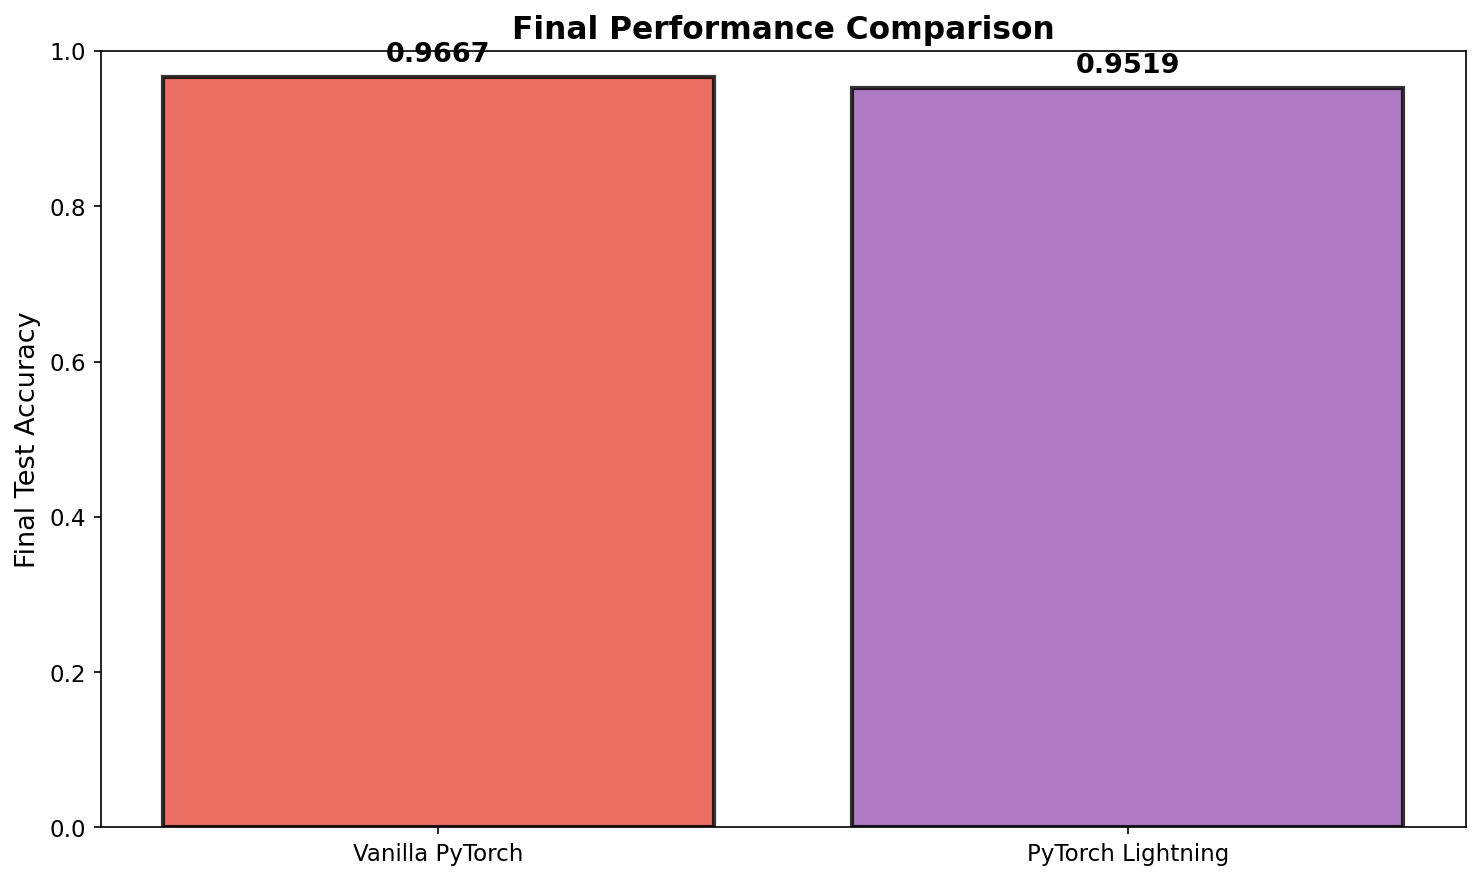

FINAL PERFORMANCE
Vanilla PyTorch:    0.9667
PyTorch Lightning:  0.9519
Difference:         0.0148


In [16]:
# Get final metrics
vanilla_final_acc = vanilla_history['val_acc'][-1]
lightning_final_acc = lightning_history['val_acc'][-1]

# Plot comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(['Vanilla PyTorch', 'PyTorch Lightning'], 
               [vanilla_final_acc, lightning_final_acc],
               color=['#e74c3c', '#9b59b6'],
               edgecolor='black',
               linewidth=2,
               alpha=0.8)
plt.ylabel('Final Test Accuracy', fontsize=13)
plt.title('Final Performance Comparison', fontsize=15, fontweight='bold')
plt.ylim([0, 1])

# Add value labels
for bar, acc in zip(bars, [vanilla_final_acc, lightning_final_acc]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{acc:.4f}', ha='center', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

print("="*60)
print("FINAL PERFORMANCE")
print("="*60)
print(f"Vanilla PyTorch:    {vanilla_final_acc:.4f}")
print(f"PyTorch Lightning:  {lightning_final_acc:.4f}")
print(f"Difference:         {abs(vanilla_final_acc - lightning_final_acc):.4f}")
print("="*60)


---

## Part 4: Advanced Lightning Features


### Step 15: Lightning with Early Stopping

Let's demonstrate one of Lightning's powerful callbacks!


In [17]:
# Create new model
advanced_model = LightningMLP(input_dim, 256, num_classes, learning_rate=1e-3)

# Trainer with early stopping
advanced_trainer = Trainer(
    max_epochs=50,  # More epochs, but early stop if not improving
    accelerator='auto',
    devices=1,
    logger=CSVLogger('logs', name='pbmc_early_stop'),
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            mode='min',
            verbose=True
        ),
        ModelCheckpoint(
            monitor='val_acc',
            mode='max',
            save_top_k=1,
            filename='best-model-{epoch:02d}-{val_acc:.3f}'
        )
    ],
    enable_progress_bar=True
)

print("Training with early stopping...")
advanced_trainer.fit(advanced_model, data_module)

print(f"\n✅ Stopped at epoch {advanced_trainer.current_epoch}")
print("💡 Early stopping prevented unnecessary training!")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | fc1       | Linear           | 512 K  | train
1 | fc2       | Linear           | 65.8 K | train
2 | out       | Linear           | 2.1 K  | train
3 | dropout   | Dropout          | 0      | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
580 K     Trainable params
0         Non-trainable params
580 K     Total params
2.320     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Training with early stopping...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.462


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.263 >= min_delta = 0.0. New best score: 0.199


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.152


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.139


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.139. Signaling Trainer to stop.



✅ Stopped at epoch 9
💡 Early stopping prevented unnecessary training!


### Step 16: Biological Analysis with Lightning Model

Lightning models work just like regular PyTorch models for inference!


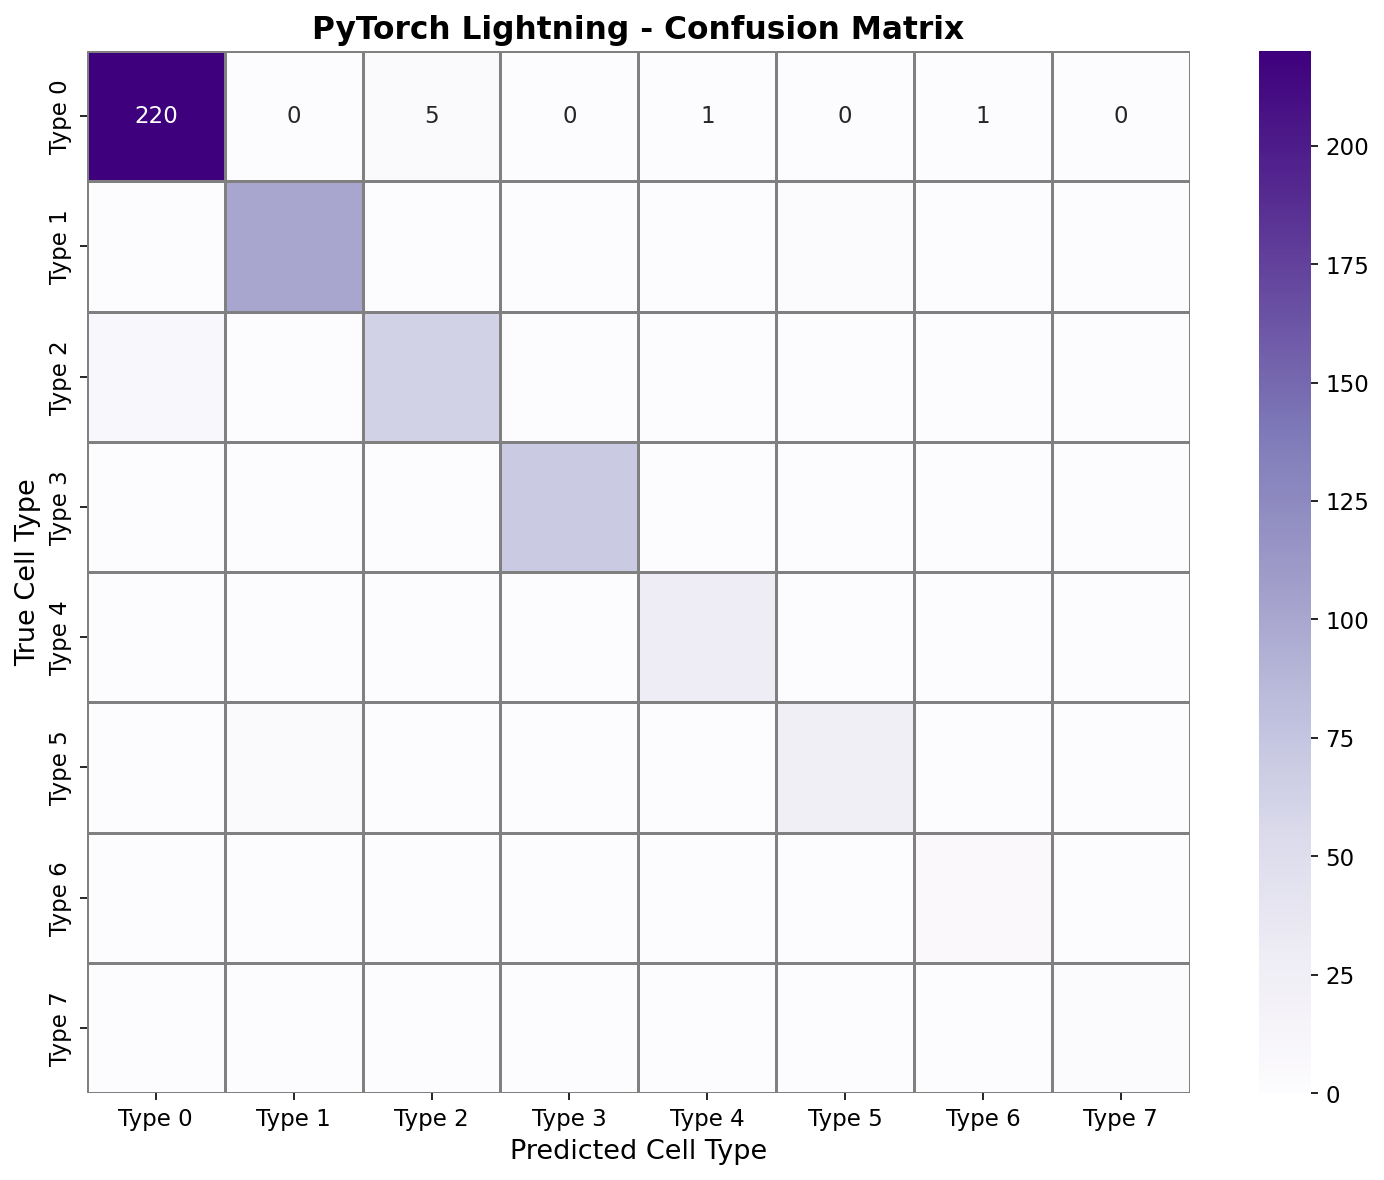

Correct predictions: 514/540 (95.2%)


In [18]:
# Get predictions
lightning_model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    predictions = lightning_model(X_test_tensor).argmax(1).numpy()

# Confusion matrix
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=[f'Type {i}' for i in range(num_classes)],
            yticklabels=[f'Type {i}' for i in range(num_classes)],
            linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Cell Type', fontsize=13)
plt.ylabel('True Cell Type', fontsize=13)
plt.title('PyTorch Lightning - Confusion Matrix', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

correct = np.trace(cm)
total = len(y_test)
print(f"Correct predictions: {correct}/{total} ({100*correct/total:.1f}%)")


---

## 🎯 Summary and Conclusions


### Key Takeaways

#### 1. **Code Clarity** ✨
- **Vanilla PyTorch**: ~85 lines of boilerplate
- **Lightning**: ~50 lines (41% reduction)
- Lightning separates "what to do" from "how to loop"

#### 2. **Automatic Features** 🤖
Lightning automatically handles:
- ✅ Device management (no `.to(device)` needed)
- ✅ Training/eval mode switching
- ✅ Gradient zeroing
- ✅ Validation loops
- ✅ Progress bars and logging
- ✅ Checkpointing and early stopping

#### 3. **Performance** ⚡
- Similar accuracy to vanilla PyTorch
- Comparable or better training time
- Easier to optimize with built-in callbacks

#### 4. **Scalability** 🚀
Multi-GPU training is trivial in Lightning:
```python
# Just change this line!
trainer = Trainer(devices=4, strategy='ddp')
```

#### 5. **Reproducibility** 🔬
- Automatic hyperparameter logging
- Built-in checkpointing
- Structured code is easier to share

### When to Use Lightning?

**Use Lightning when:**
- ✅ You want cleaner, more organized code
- ✅ You need to scale to multiple GPUs
- ✅ You want built-in best practices
- ✅ You're doing research and need reproducibility
- ✅ You want to spend more time on models, less on boilerplate

**Stick with vanilla PyTorch when:**
- You have very custom training loops
- You're implementing novel training algorithms
- You need maximum control over every detail

### Best Practices with Lightning

1. 🎯 **Use DataModules** for data organization
2. 🎯 **Log everything** with `self.log()`
3. 🎯 **Use callbacks** for early stopping, checkpointing
4. 🎯 **Save hyperparameters** with `self.save_hyperparameters()`
5. 🎯 **Structure code** into logical methods

---

## 🎉 Conclusion

**PyTorch Lightning streamlines deep learning by:**
- Reducing boilerplate code by ~40%
- Automating best practices
- Making code more readable and reproducible
- Enabling easy scaling to multiple GPUs

**Same performance, cleaner code, better workflow!** ⚡

For more information:
- [PyTorch Lightning Documentation](https://lightning.ai/docs/pytorch/stable/)
- [Lightning Examples](https://github.com/Lightning-AI/lightning/tree/master/examples)
